Memulai ekstraksi fitur...
Memproses folder: Ciherang
  Telah memproses 10 file dari Ciherang
  Telah memproses 20 file dari Ciherang
  Telah memproses 30 file dari Ciherang
  Telah memproses 40 file dari Ciherang
  Telah memproses 50 file dari Ciherang
  Telah memproses 60 file dari Ciherang
  Telah memproses 70 file dari Ciherang
  Telah memproses 80 file dari Ciherang
  Telah memproses 90 file dari Ciherang
  Telah memproses 100 file dari Ciherang
  Telah memproses 110 file dari Ciherang
  Telah memproses 120 file dari Ciherang
  Telah memproses 130 file dari Ciherang
  Telah memproses 140 file dari Ciherang
  Telah memproses 150 file dari Ciherang
  Telah memproses 160 file dari Ciherang
  Telah memproses 170 file dari Ciherang
  Telah memproses 180 file dari Ciherang
  Telah memproses 190 file dari Ciherang
  Telah memproses 200 file dari Ciherang
  Telah memproses 210 file dari Ciherang
  Telah memproses 220 file dari Ciherang
  Telah memproses 230 file dari Ciherang
  Telah memp

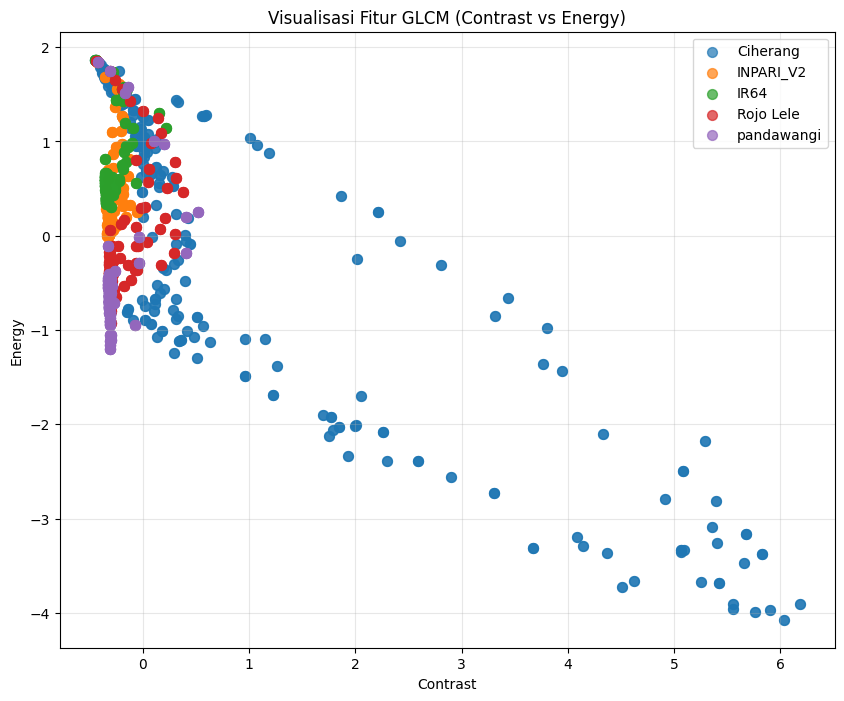

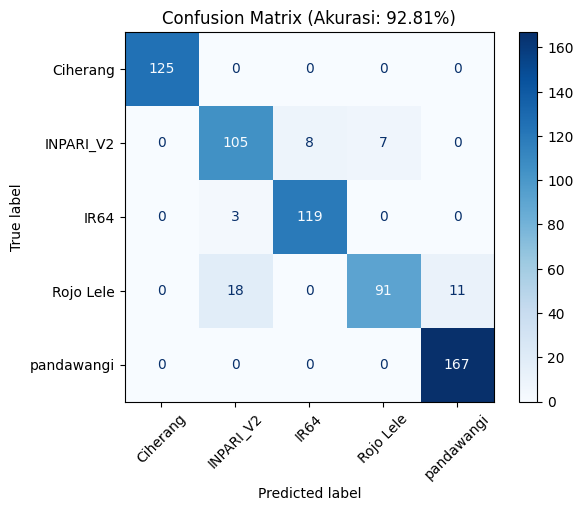

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from skimage.feature import graycomatrix, graycoprops
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# TensorFlow untuk MobileNet
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model

# === 1. Folder dataset ===
dataset_path = r"C:\Users\Raga Triagantara\Archives\Projects\Program GLCM\GABAH"

# === Fungsi Gray-World Normalization ===
def gray_world_norm(img):
    B, G, R = cv2.split(img.astype(np.float32))
    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    mean_gray = (mean_R + mean_G + mean_B) / 3
    R = np.clip(R * (mean_gray / mean_R), 0, 255)
    G = np.clip(G * (mean_gray / mean_G), 0, 255)
    B = np.clip(B * (mean_gray / mean_B), 0, 255)
    return cv2.merge([B, G, R]).astype(np.uint8)

# === Fungsi Otsu-Tangen ===
def otsu_tan(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t, max_sigma = 0, 0
    w0, sum0 = 0.0, 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        sigma_b = w0 * w1 * (math.tan(mu0 - mu1)) ** 2
        if sigma_b > max_sigma:
            max_sigma, best_t = sigma_b, t
    return best_t

# === Fungsi ekstraksi fitur GLCM ===
def glcm_features(img_gray):
    glcm = graycomatrix(img_gray,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True,
                        normed=True)
    features = {
        "contrast": graycoprops(glcm, 'contrast').mean(),
        "correlation": graycoprops(glcm, 'correlation').mean(),
        "energy": graycoprops(glcm, 'energy').mean(),
        "homogeneity": graycoprops(glcm, 'homogeneity').mean()
    }
    return list(features.values())

# === Ekstraksi fitur dengan MobileNet ===
def extract_mobilenet_features(img):
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input(img_array)
    features = mobilenet_model.predict(img_preprocessed, verbose=0)
    return features.flatten()

# === Load Pretrained MobileNet ===
mobilenet_base = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=mobilenet_base.output)

# === Fungsi ekstraksi fitur sederhana untuk menggantikan CapsNet ===
def extract_simple_cnn_features(img):
    # Resize dan normalisasi
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0
    img_array = np.expand_dims(img_normalized, axis=0)
    
    # Gunakan beberapa layer dari MobileNet sebagai fitur
    intermediate_model = Model(
        inputs=mobilenet_model.input,
        outputs=[
            mobilenet_model.get_layer('conv_pw_5_relu').output,  # Layer menengah
            mobilenet_model.get_layer('conv_pw_10_relu').output  # Layer lebih dalam
        ]
    )
    
    features_list = intermediate_model.predict(img_array, verbose=0)
    
    # Flatten dan gabungkan fitur
    flattened_features = []
    for feat in features_list:
        flattened_features.append(feat.flatten())
    
    return np.concatenate(flattened_features)

# === 2. Loop semua gambar & ekstraksi fitur ===
X, y = [], []
processed_count = 0

print("Memulai ekstraksi fitur...")

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_path):
        continue
    
    print(f"Memproses folder: {class_folder}")
    file_count = 0
    
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue

        try:
            # Gray-World Normalization
            img_norm = gray_world_norm(img)
            img_gray = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)

            # Histogram & Otsu-Tan Threshold
            hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
            hist = hist.ravel() / hist.sum()
            t_tan = otsu_tan(hist)
            _, th_tan = cv2.threshold(img_gray, t_tan, 255, cv2.THRESH_BINARY)

            # GLCM Fitur
            glcm_feats = glcm_features(th_tan.astype(np.uint8))

            # MobileNet Features
            mobilenet_feats = extract_mobilenet_features(img_norm)

            # CNN Intermediate Features (menggantikan CapsNet)
            cnn_feats = extract_simple_cnn_features(img_norm)

            # Gabungkan semua fitur
            combined_features = np.concatenate([glcm_feats, mobilenet_feats, cnn_feats])
            X.append(combined_features)
            y.append(class_folder)
            
            file_count += 1
            processed_count += 1
            
            if file_count % 10 == 0:
                print(f"  Telah memproses {file_count} file dari {class_folder}")
                
        except Exception as e:
            print(f"  Error memproses {filename}: {str(e)}")
            continue

print(f"Selesai! Total {processed_count} gambar diproses.")

# === 3. Split data dan normalisasi ===
X = np.array(X)
print(f"Dimensi fitur: {X.shape}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# === 4. Klasifikasi dengan Random Forest ===
print("Melatih Random Forest...")
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"✅ Akurasi Random Forest: {acc*100:.2f}%\n")

# === 5. Classification Report ===
report = classification_report(y_test, y_pred, target_names=le.classes_)
print("=== Classification Report ===")
print(report)

# === 6. Visualisasi ===
# a. Scatter plot 2 fitur (contoh: contrast vs energy)
plt.figure(figsize=(10, 8))
for label in np.unique(y_encoded):
    mask = y_encoded == label
    plt.scatter(X_scaled[mask, 0],  # contrast
                X_scaled[mask, 2],  # energy
                label=le.classes_[label],
                alpha=0.7,
                s=50)
plt.xlabel("Contrast")
plt.ylabel("Energy")
plt.title("Visualisasi Fitur GLCM (Contrast vs Energy)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# b. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix (Akurasi: {acc*100:.2f}%)")
plt.show()